# Press m to activate markdown mode

So, what is collection in tensorflow？ In fact, you just take collection as a global container.
collection will store all Variables added as a list. You can use get function through name obtain the list.
For simple understanding, you can take each collection as a list with a name.
In general, we need call add_n to sum losses up when refer to regularizition loss



this section, I capsule layer as a function. In the mean time, we use exponential decay learning rate as a fine tuning
mechanism. the learning_rate will become less and less with the iteration. 
However, the change follows a stair down procedure, that is the learning rate keeps still for some iterations, say 100 times.
after 100 times iterations. the learning rate goes down for a step
you need set several variables in the formula, which is:
1. set global_step as 0
for each iteration, update the learning_rate as:
    decay_learning_rate = base_learning_rate * decay_rate ^ (global_step/decay_rate)
if you do not apply decay, base_learning_rate will be your choice. The decay rate is usually set as a < 1 variable.
from the formula, we can obtain that, with the bigger global_step, decay_rate ^ (global_step/decay_rate) will decay more.
That is, learning rate will be less after sufficient iterations.


Another decay mechanism we need apply is average exponential average average for each parameters.



In [2]:
#### You must restart the kernel each time when running the program through jupyter
#### because collection is a global data struct which is still in memory
#### after last running.

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#import pdb

learning_rate = 0.1
batch_size = 1000
regular_rate = 0.1

moving_average_decay = 0.99

print("helloworldrewrsdfa")
#######for regularizition
regularizer = tf.contrib.layers.l2_regularizer

global_step = tf.Variable(0, trainable=False)
######## for exponentail moving average
#variables_averages = tf.train.ExponentialMovingAverage(moving_average_decay, global_step)
#variables_average_op = variables_averages.apply(tf.trainable_variables())

global_step = tf.Variable(0, trainable=False)
variable_averages = tf.train.ExponentialMovingAverage(moving_average_decay, global_step)
variables_averages_op = variable_averages.apply(tf.trainable_variables())

def layer(input_size:int, output_size:int, prelayer, avg_class, act_func):
    w = tf.Variable(tf.random_normal([input_size, output_size], stddev=0.1))
    b = tf.Variable(tf.random_normal([output_size], stddev=0.1))
    tf.add_to_collection('losses', regularizer(0.001)(w))
    print("avg_class", avg_class)
    if avg_class != None:
        print(w, b)
        #pdb.set_trace()
        aw = avg_class.average(w)
        ab = avg_class.average(b)
        print(prelayer, aw, ab)
        aaa = tf.matmul(prelayer, aw) +ab
        ret = act_func(aa)
        return ret
    return act_func(tf.matmul(prelayer, w) + b)

x = tf.placeholder(tf.float32, shape=(None, 1), name='x')
y_ = tf.placeholder(tf.float32, shape=(None, 1), name='y_')


# build net without average class
L1 = layer(1, 3, x, None, tf.nn.relu)
L2 = layer(3, 2, L1, None, tf.nn.relu)
y = layer(2, 1, L2, None, tf.nn.sigmoid)


##data
size = 1000
X = np.random.normal(0, 1, size)
Y = [0. if lx<0 else 1. for lx in X]

#av_L1 = layer(1, 3, x, variable_averages, tf.nn.relu)
#av_L2 = layer(3, 2, av_L1, variable_averages, tf.nn.relu)
#av_y = layer(2, 1, av_L2, variable_averages, tf.nn.sigmoid)

######for exponential decay
###1. learning_rate, 2.global_step, 3.decay_steps, 4.decay_rate, 5.staircase, 6.name
learning_rate = tf.train.exponential_decay(0.1, global_step, 100, 0.96, staircase=True)

closs = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=tf.clip_by_value(y, 1e-8, 1.0)))

#mse_loss = tf.reduce_mean(tf.square(y_-y))

##############
#tf.add_to_collection('losses', mse_loss)
tf.add_to_collection('losses', closs)
losses= tf.get_collection('losses')
loss = tf.add_n(losses, name='loss')

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
train_op = tf.group(optimizer, variables_averages_op)
#optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(10000):
        start = (i*batch_size)%size
        end = min(start+batch_size, size) 
        xs, ys = X[start:end].reshape(end-start, 1), np.array(Y[start:end]).reshape(end-start, 1)
        #print(start, end, len(xs), len(ys))
        sess.run(train_op, feed_dict={x:xs, y_:ys})
        if i%1000==999:
            print(i+1, sess.run(tf.reduce_mean( sess.run(loss, feed_dict={x:xs, y_:ys}) )))
    xx = np.linspace(-5,5, 1000).reshape(1000, 1)
    #y = sess
    py = sess.run(y, feed_dict={x:xx})
    plt.plot(xx, py)

helloworldrewrsdfa
avg_class None
avg_class None
avg_class None


InvalidArgumentError: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,1]
	 [[Node: x = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'x', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-de93b26e26da>", line 73, in <module>
    x = tf.placeholder(tf.float32, shape=(None, 1), name='x')
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 1777, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 4521, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'x' with dtype float and shape [?,1]
	 [[Node: x = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [3]:
import tensorflow as tf
import numpy as np


v1 = tf.get_variable(name='v1', shape=[1], initializer=tf.constant_initializer(5))  
tf.add_to_collection('loss', v1)  
v2 = tf.get_variable(name='v2', shape=[1], initializer=tf.constant_initializer(8))  
tf.add_to_collection('loss', v2)  
  
with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())  
    print(tf.get_collection('loss'))
    print(sess.run(tf.add_n(tf.get_collection('loss'))))

[<tf.Variable 'v1:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'v2:0' shape=(1,) dtype=float32_ref>]
[13.]


# hello world 
### you can say something
1. sfsf
1. fdsf
1. fdsfjskl


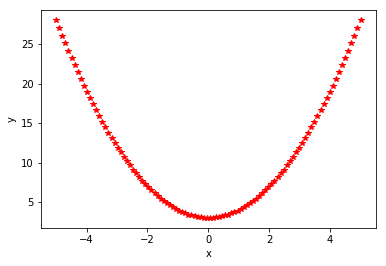

HelloWolrd


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-5, 5, 100)
y = x**2 + 3

z = [3, 5, 7, 9]
plt.xlabel("x")
plt.ylabel("y")
#plt.legend("x2+3")
plt.plot(x, y, "r*")
#plt.hist(z)
plt.show()
print("HelloWolrd")